In [1]:
import json
import pickle
import os


from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import autolens as al
import autolens.plot as aplt

from plotbin.plot_velfield import plot_velfield
from jampy.mge_radial_mass import mge_radial_mass
from jampy.mge_radial_density import mge_radial_density
from jampy.mge_half_light_isophote import mge_half_light_isophote
from astropy import units as u

In [2]:
result_path = "/home/carlosmelo/Documents/GitHub/TaleI/341482/model1"
phase_name = "phase5"
result_path   = result_path+"/"+phase_name  #path to the non-linear results

In [3]:
with open(result_path+'/Final_sampler_{}.pickle'.format(phase_name),'rb') as f:
    sampler = pickle.load(f)
    f.close()

with open(result_path+'/{}.pickle'.format(phase_name),'rb') as f:
    phase = pickle.load(f)
    f.close()

with open(result_path+'/CombinedModel_{}.pickle'.format(phase_name),'rb') as f:
    CM = pickle.load(f)
    f.close()

with open(result_path+'/priors_{}.pickle'.format(phase_name),'rb') as f:
    priors = pickle.load(f)
    f.close()

sampler = sampler["sampler"]
sampler.results.summary()

Summary
nlive: 500
niter: 5031
ncall: 68993
eff(%):  8.017
logz: 4501.345 +/-  0.156


In [4]:
# Generate a new set of results with statistical+sampling uncertainties.
labels = list(priors.keys())
parsRes = priors.copy()
results_sim = dyfunc.jitter_run(dyfunc.resample_run(sampler.results))
samples_sim, weights = results_sim.samples, results_sim.importance_weights()
quantiles = [dyfunc.quantile(samps, [0.16, 0.5,  0.84], weights=weights)
            for samps in samples_sim.T]                        #quantiles for each parameter

    #Update the parameters
for i, key in enumerate(parsRes.keys()):
    parsRes[key] = quantiles[i][1]

In [5]:
adp_pix = phase.source_pix(pixels=int(phase.parsSource["pixels"]),
                            weight_floor=phase.parsSource["weight_floor"],
                            weight_power=phase.parsSource["weight_power"]
                            )

adp_reg = phase.source_reg(inner_coefficient=phase.parsSource["inner_coefficient"],
                            outer_coefficient=phase.parsSource["outer_coefficient"],
                            signal_scale=phase.parsSource["signal_scale"]
                            )

source_model = al.Galaxy(redshift=CM.Lens_model.z_s,
                            pixelization=adp_pix, regularization=adp_reg,
                            hyper_model_image=phase.hyper_image_2d,
                            hyper_galaxy_image=phase.hyper_image_2d,
                            )

CM.source_galaxy(source_model=source_model)  #Setting the source galaxy model

CM.quiet = True
CM.Updt_Model(parsRes)

Parameters Updated!


In [8]:
einstein_radius = CM.Fit.tracer.einstein_radius_from(CM.Fit.imaging.unmasked.grid, pixel_scale=0.09, )

In [9]:
einstein_radius

Grid2DIrregular(1.2316207)

In [10]:
kappa = CM.Fit.tracer.convergence_2d_via_jacobian_from(CM.Fit.imaging.unmasked.grid)

In [11]:
from astropy.io import fits

In [49]:
kappa1 = fits.open("/home/carlosmelo/Documents/GitHub/Illustris/my_illustris/TNG50-1-snap84-subhalo341482/imgs/surface_mass_density.fits")

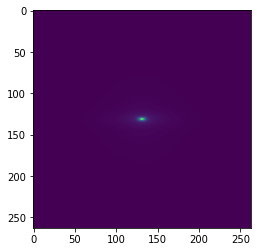

In [44]:
import matplotlib.pyplot as plt
plt.imshow(kappa.native)

In [57]:
CM.Fit.imaging.grid[:,0].shape

(2417,)

In [59]:
CM.Fit.imaging.unmasked.grid[:,1]

(69169,)

In [60]:
y_grid, x_grid =  CM.Fit.imaging.unmasked.grid[:,0], CM.Fit.imaging.unmasked.grid[:,1] 

In [63]:
import numpy as np
np.diff(y_grid)

Grid2D([0., 0., 0., ..., 0., 0., 0.])

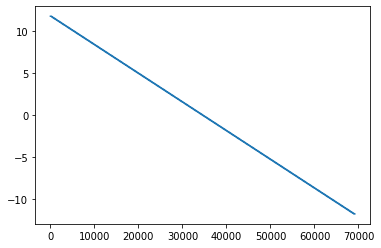

In [65]:
plt.plot(y_grid)

In [67]:
help(al.Grid2D.uniform)

Help on method uniform in module autoarray.structures.grids.uniform_2d:

uniform(shape_native: Tuple[int, int], pixel_scales: Union[Tuple[float], Tuple[float, float], float], sub_size: int = 1, origin: Tuple[float, float] = (0.0, 0.0)) -> 'Grid2D' method of abc.ABCMeta instance
    Create a `Grid2D` (see *Grid2D.__new__*) as a uniform grid of (y,x) values given an input `shape_native` and
    `pixel_scales` of the grid:
    
    Parameters
    ----------
    shape_native
        The 2D shape of the uniform grid and the mask that it is paired with.
    pixel_scales
        The (y,x) scaled units to pixel units conversion factors of every pixel. If this is input as a `float`,
        it is converted to a (float, float) tuple.
    sub_size
        The size (sub_size x sub_size) of each unmasked pixels sub-grid.
    origin
        The origin of the grid's mask.



In [112]:
def effective_einstein_radius_from_kappa(kappa, grid_spacing, grid=None, Nsamples=1000,  
                                           get_precision=False, verbose=True):
    """
    This function is originally from the code lenstronomy (https://lenstronomy.readthedocs.io/en/stable/), 
    implemented at: 
    https://github.com/AlexandreAdam/lenstronomy/blob/acfc0e8c5577e59fc20d3bcd4657bf50bd007ee2/lenstronomy/Analysis/lens_profile.py#L159

    Here we made some modifications to allow the calculation of the Effective Einstein ring 
    from kappa (i.e. convergence map) derived either from a mass model or hydrodynamical simulation.



    Computes the radius with mean convergence=1
    
    Inputs:
    ----------------------
    kappa [Ad]: 2d-array
        2d convergence map. The pixel scale should be the same
        as in grid_spacing.
    grid_spacing [arcsec]: float 
        spacing in angular units of the grid.
    
    Optional:
    ----------------------
    grid [arcsec]: 2d-array
        grid of (y,x) arcsec coordinates used to estimate the Einstein radius.
        If None, uses the kappa grid coordinates.
    Nsamples: int
        number of grid points to numerically evaluate the convergence and 
        estimate the Einstein radius
    
    get_precision: bool
        if True, return the precision of estimated Einstein radius
    verbose: bool, 
        if True prints warning if indication of insufficient result 
    
    Output:
    ---------------------
    thetaE [arcsec]: float
        estimate of the Einstein radius
    """
    
    if grid is None:
        grid = al.Grid2D.uniform(shape_native=(kappa.shape[0], kappa.shape[0]),
                                          pixel_scales=grid_spacing) 
    else: pass   
        
    
    r_array = np.linspace(0, kappa.shape[0]*grid_spacing/2., Nsamples)
    kappa_flat = kappa.flatten()

    for r in r_array:
        mask = np.array(1 - al.Mask2D.circular(shape_native=grid.shape_native,
                                                radius=r,
                                                pixel_scales=grid_spacing))
        mask = mask.flatten()
        sum_mask = np.sum(mask)
        if sum_mask > 0:
            kappa_mean = np.sum(kappa_flat*mask)/np.sum(mask)
            if kappa_mean < 1:
                if get_precision:
                    return r, r_array[1] - r_array[0]
                else:
                    return r
    if verbose:
            Warning("No Einstein radius computed for this convergence map!")
    return np.nan

In [117]:
effective_einstein_radius_from_kappa(kappa.native, 0.09, grid=grid)

1.2083783783783781

In [116]:
grid

Grid2D([[ 11.79, -11.79],
        [ 11.79, -11.7 ],
        [ 11.79, -11.61],
        ...,
        [-11.79,  11.61],
        [-11.79,  11.7 ],
        [-11.79,  11.79]])

In [109]:
mask = al.Mask2D.circular(shape_native=grid.shape_native,
                                        radius=1.23,
                                        pixel_scales=0.09)

In [110]:
sum(1- mask.flatten())

593